# Getting all coins from Messari API

In [38]:
# libraries
import json
import requests
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import os

In [39]:
def loadJSON(filepath):
    with open(filepath) as file:
        return json.load(file)

## Getting all the tokens from the all time high endpoint

In [40]:
def get_from_api(endpoint: str, API_KEY: str):
    base_url = 'https://api.messari.io/'
    url = f'{base_url}{endpoint}'
    headers = {
        'accept': 'application/json',
        'x-messari-api-key': API_KEY,
    }
    return requests.get(url, headers=headers)

# API key from environment variable
API_KEY = os.getenv('MESSARI_ANDRE_KEY')

In [14]:
response = get_from_api('marketdata/v1/assets/ath', API_KEY)

In [15]:
if response.status_code == 200:
    result = response.json()

    data = result['data']

    with open('../data/raw/all-tokens.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

    print(f"Information saved in '../data/raw/all-tokens.json'. Number of tokens: {len(data)}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Information saved in '../data/raw/all-tokens.json'. Number of tokens: 14731


## Filtering the coins

Since we have the tokens organized by the objective categories in `logical-model/data/csv`, wee need to get rid of the ones with market cap 0.

In [41]:
# libraries
import pandas as pd

In [42]:
ai_df = pd.read_csv('../../logical-model/data/csv/coins_AI.csv')
gaming_df = pd.read_csv('../../logical-model/data/csv/coins_gaming.csv')
meme_df = pd.read_csv('../../logical-model/data/csv/coins_meme.csv')
rwa_df = pd.read_csv('../../logical-model/data/csv/coins_RWA.csv')

print("Shapes of the dataframes:", ai_df.shape, gaming_df.shape, meme_df.shape, rwa_df.shape)
print("Number of tokens: ", ai_df.shape[0] + gaming_df.shape[0] + meme_df.shape[0] + rwa_df.shape[0])

Shapes of the dataframes: (250, 17) (400, 17) (500, 17) (100, 17)
Number of tokens:  1250


### Preprocessing data before filtering

In [43]:
def remove_non_market_cap(df: pd.DataFrame) -> pd.DataFrame:
    df_without_null = df.dropna(subset=['market_cap'])
    return df_without_null[df_without_null['market_cap'] != 0]

In [44]:
ai_df = remove_non_market_cap(ai_df)
gaming_df = remove_non_market_cap(gaming_df)
meme_df = remove_non_market_cap(meme_df)
rwa_df = remove_non_market_cap(rwa_df)

print("Shapes of the dataframes:", ai_df.shape, gaming_df.shape, meme_df.shape, rwa_df.shape)
print("Number of tokens: ", ai_df.shape[0] + gaming_df.shape[0] + meme_df.shape[0] + rwa_df.shape[0])

Shapes of the dataframes: (167, 17) (261, 17) (220, 17) (75, 17)
Number of tokens:  723


### Filtering by category

In [45]:
# read the json file with all tokens
tokens = loadJSON('../data/raw/all-tokens.json')
len(tokens)

14731

In [46]:
def filter_by_category(category_df: pd.DataFrame, tokens: list) -> pd.DataFrame:
    return [
        record for record in tokens
        if (record['name'] in category_df['name'].values) and
        # (record['slug'] in category_df['slug'].values) and
        (record['symbol'] in category_df['symbol'].astype(str).values)
    ]

In [47]:
meme = filter_by_category(category_df=meme_df, tokens=tokens)
gaming = filter_by_category(category_df=gaming_df, tokens=tokens)
ai = filter_by_category(category_df=ai_df, tokens=tokens)
rwa = filter_by_category(category_df=rwa_df, tokens=tokens)

print("Number of tokens:", len(ai), len(gaming), len(meme), len(rwa))
print("Number of tokens:", len(meme) + len(gaming) + len(ai) + len(rwa))

Number of tokens: 80 117 34 38
Number of tokens: 269


## Getting yearly data from messari endpoint

In [48]:
# libraries
import time
from datetime import datetime, timedelta

In [49]:
def getting_interval_timestamps(date: str, days:int) -> tuple[int, int]:
    startdate: datetime = datetime.strptime(date, '%d/%m/%Y')
    enddate: datetime = startdate + timedelta(days=days)
    return int(datetime.timestamp(startdate)), int(datetime.timestamp(enddate))

In [50]:
def get_yearly_data(date_since:str, interval:str, tokens: list, category: str)->None:
    year = date_since

    while(1):
        print(f"Getting data since {year}")
        annual_data = []

        days = 360

        if datetime.now() - timedelta(days=360) < datetime.strptime(year, "%d/%m/%Y"):
            days = int((datetime.now() - datetime.strptime(year, "%d/%m/%Y")).days)
        
        start_timestamp, end_timestamp = getting_interval_timestamps(year, days)
        print(f"{start_timestamp} - {end_timestamp} ({days} days)")
        
        for token in tokens:
            new_token = token.copy()
            del new_token['allTimeHighData']
            del new_token['cycleLowData']
            new_token['category'] = category
            endpoint = f"marketdata/v1/assets/{token["id"]}/price/time-series?interval={interval}&startTime={start_timestamp}&endTime={end_timestamp}"
            response = get_from_api(endpoint, API_KEY)
            if response.status_code == 200:
                result = response.json()
                new_token['market_data'] = result['data']
            else:
                new_token['market_data'] = "No content"
            annual_data.append(new_token)
        
        with open(f'../data/raw/{category}/{category}-{year[6:]}.json', 'w') as json_file:
            json.dump(annual_data, json_file, indent=4)
        
        # updating year
        next_year = datetime.strptime(year, "%d/%m/%Y") + timedelta(days=days)
        year = next_year.strftime("%d/%m/%Y")

        if days < 360:
            break

In [51]:
get_yearly_data('30/09/2024', '1d', meme, 'meme')

Getting data since 30/09/2024
1727672400 - 1729918800 (26 days)


In [52]:
get_yearly_data('30/09/2024', '1d', gaming, 'gaming')

Getting data since 30/09/2024
1727672400 - 1729918800 (26 days)


In [53]:
get_yearly_data('30/09/2024', '1d', ai, 'ai')

Getting data since 30/09/2024
1727672400 - 1729918800 (26 days)


In [54]:
get_yearly_data('30/09/2024', '1d', rwa, 'rwa')

Getting data since 30/09/2024
1727672400 - 1729918800 (26 days)


## Concat category from all years

In [71]:
def complete_historical_data(category: str):
    complete_data = []
    for file in os.listdir(f'../data/raw/{category}'):
        with open(f'../data/raw/{category}/{file}') as json_file:
            data = json.load(json_file)
            if complete_data == []:
                complete_data = data
            else:
                for record in complete_data:
                    for new_record in data:
                        if record['id'] == new_record['id']:
                            if record['market_data'] == "No content":
                                record['market_data'] = new_record['market_data']
                            elif new_record['market_data'] != "No content":
                                record['market_data'] += new_record['market_data']
                            break
                                
    return complete_data

In [72]:
meme_complete = complete_historical_data('meme')
gaming_complete = complete_historical_data('gaming')
ai_complete = complete_historical_data('ai')
rwa_complete = complete_historical_data('rwa')

In [73]:
print("Number of tokens:", len(ai_complete), len(gaming_complete), len(meme_complete), len(rwa_complete))

Number of tokens: 80 117 34 38


In [74]:
def save_json(json_variable: list, category: str):
    with open(f'../data/processed/{category}.json', 'w') as json_file:
            json.dump(json_variable, json_file, indent=4)

In [75]:
save_json(meme_complete, 'meme')
save_json(gaming_complete, 'gaming')
save_json(ai_complete, 'ai')
save_json(rwa_complete, 'rwa')

In [76]:
def historical_json_to_dataframe(json_file: list) -> pd.DataFrame:
    # json_file has the property 'market_data' that is a list of dictionaries i want every single one of them to be a row with and put the name, symbol and id aswell
    data = []
    for token in json_file:
        for record in token['market_data']:
            new_record = record.copy()
            new_record['name'] = token['name']
            new_record['symbol'] = token['symbol']
            new_record['id'] = token['id']
            new_record['category'] = token['category']
            data.append(new_record)
    return pd.DataFrame(data)

In [77]:
meme_df = historical_json_to_dataframe(meme_complete)
gaming_df = historical_json_to_dataframe(gaming_complete)
ai_df = historical_json_to_dataframe(ai_complete)
rwa_df = historical_json_to_dataframe(rwa_complete)

In [78]:
meme_df.to_csv('../data/processed/meme.csv', index=False)
gaming_df.to_csv('../data/processed/gaming.csv', index=False)
ai_df.to_csv('../data/processed/ai.csv', index=False)
rwa_df.to_csv('../data/processed/rwa.csv', index=False)

In [79]:
def cast_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    return df

In [80]:
meme_df = cast_timestamp(meme_df)
gaming_df = cast_timestamp(gaming_df)
ai_df = cast_timestamp(ai_df)
rwa_df = cast_timestamp(rwa_df)

In [81]:
import matplotlib.pyplot as plt

In [82]:
def historical_plot(tokens: pd.DataFrame, main_token: str = "", limit_coins: int = 15):
    plt.figure(figsize=(20, 10))
    ax = plt.gca()
    ax.set_yscale('log')

    if main_token != "":
        always_show_group = tokens[tokens['name'] == main_token]
        if not always_show_group.empty:
            always_show_group.sort_index().plot.line(y="close", label=main_token, ax=ax)
            
    counter = 0
    for name, group in tokens.groupby("name"):
        if name != main_token:
            if counter < limit_coins:
                sorted_group = group.sort_index()
                sorted_group.plot.line(y="close", label=name, ax=ax)
                counter += 1
            else:
                break

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()


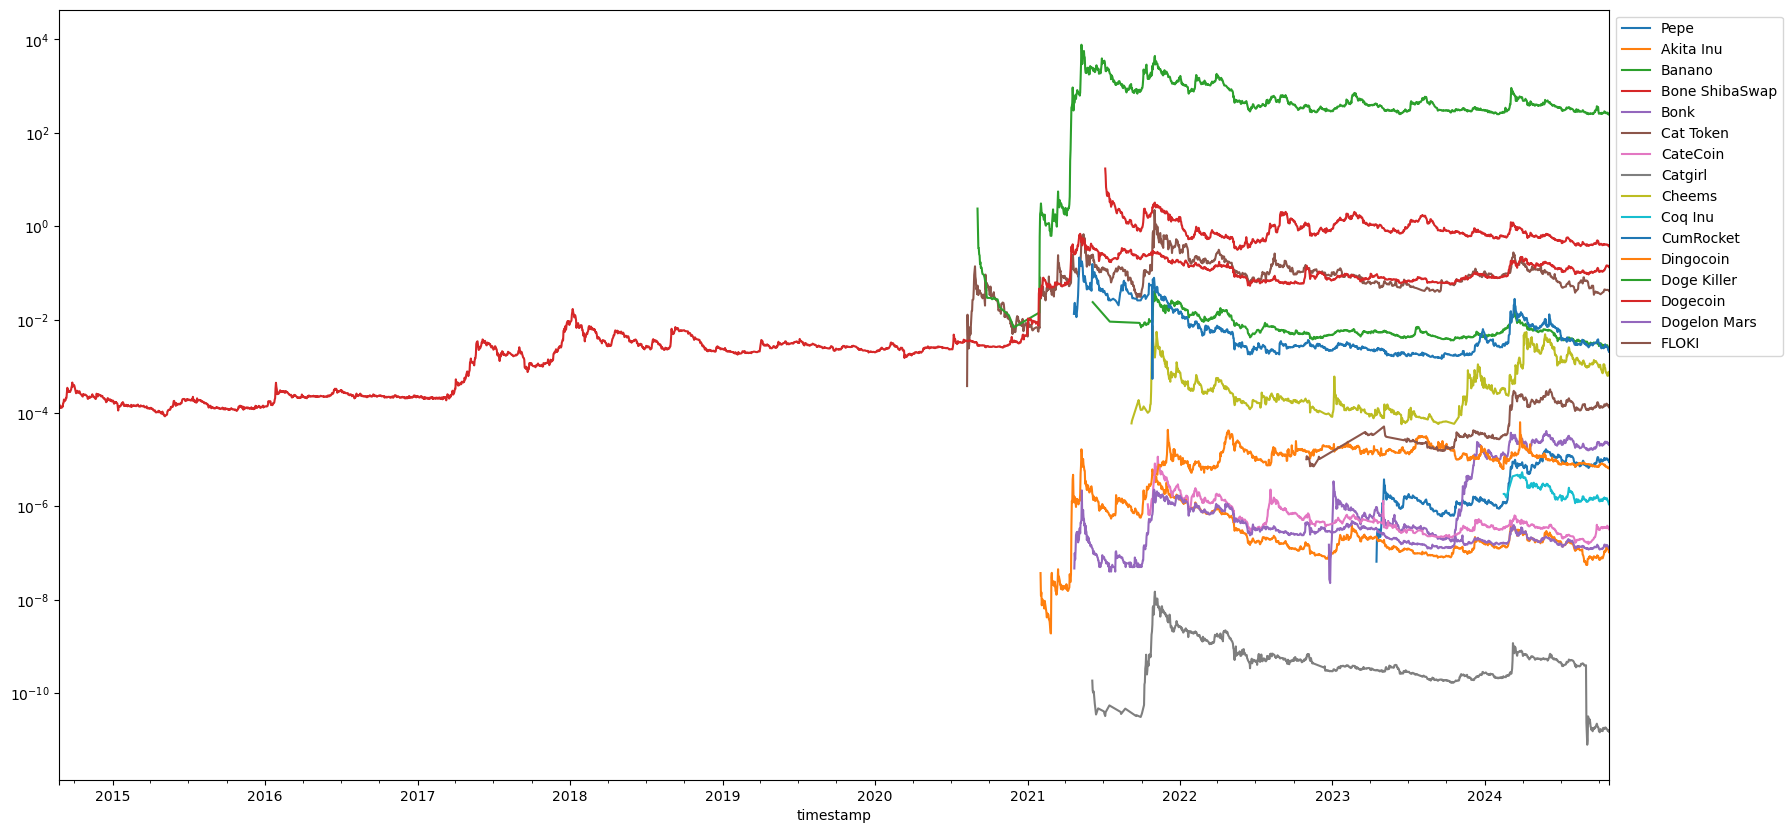

In [83]:
historical_plot(meme_df, main_token= "Pepe")

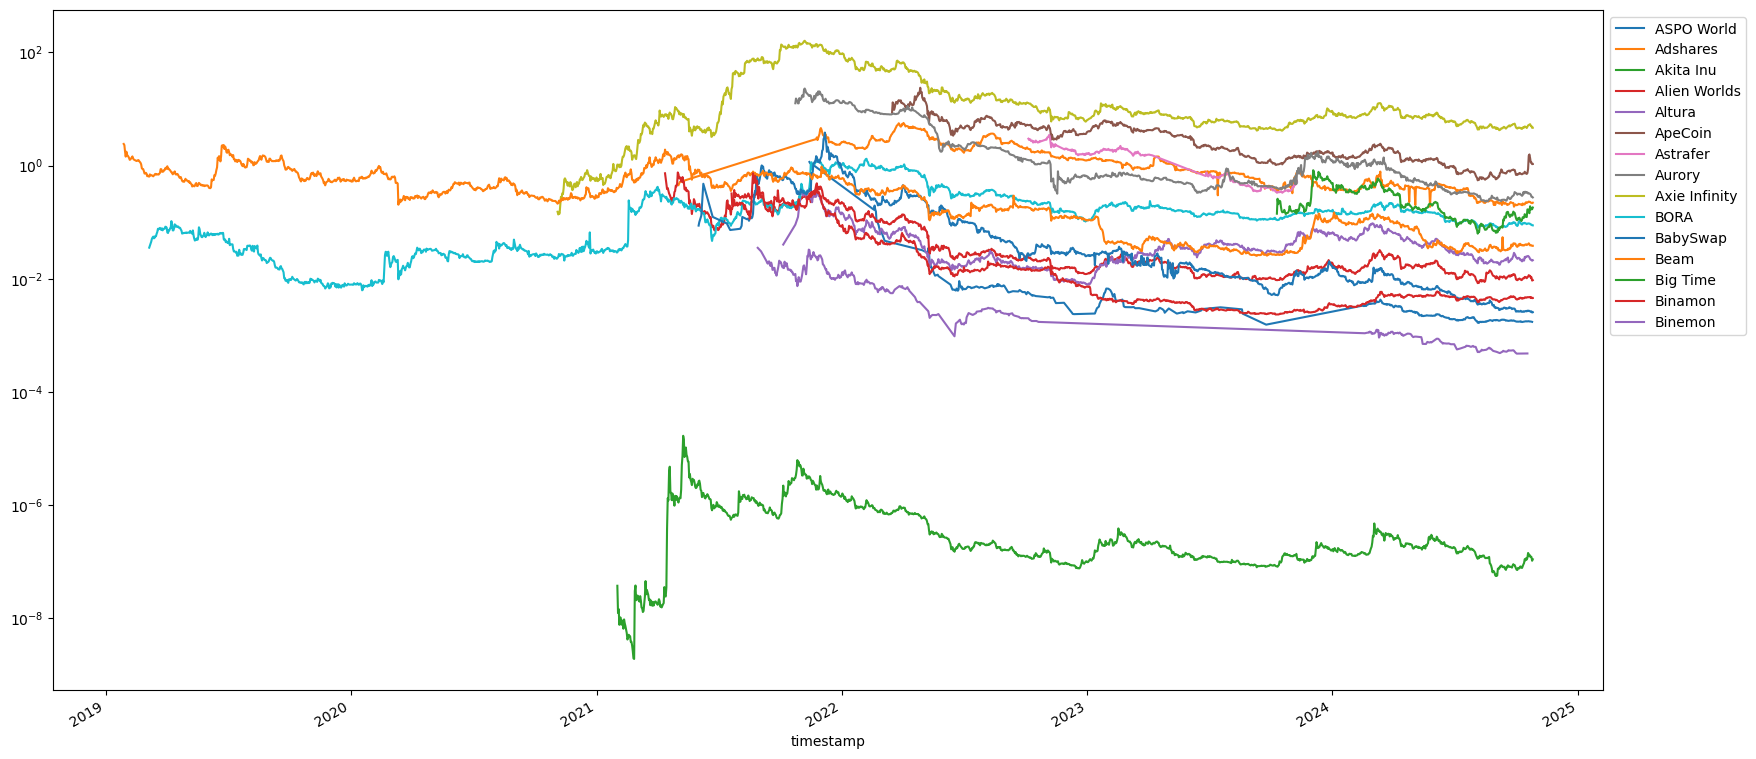

In [84]:
historical_plot(gaming_df)

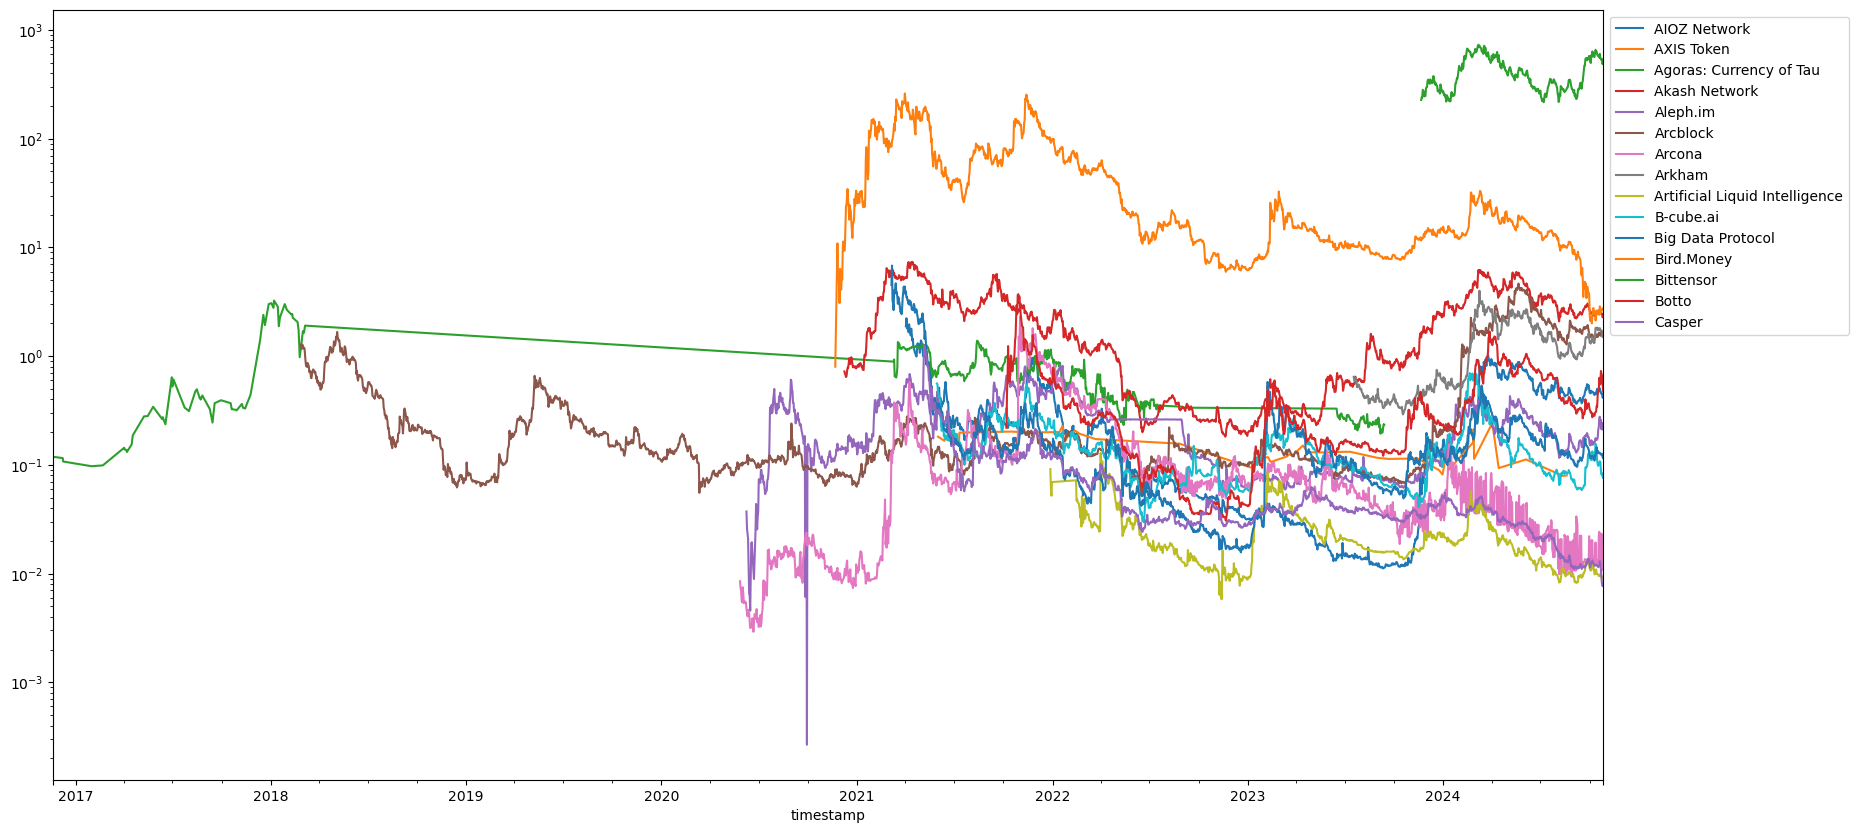

In [85]:
historical_plot(ai_df)

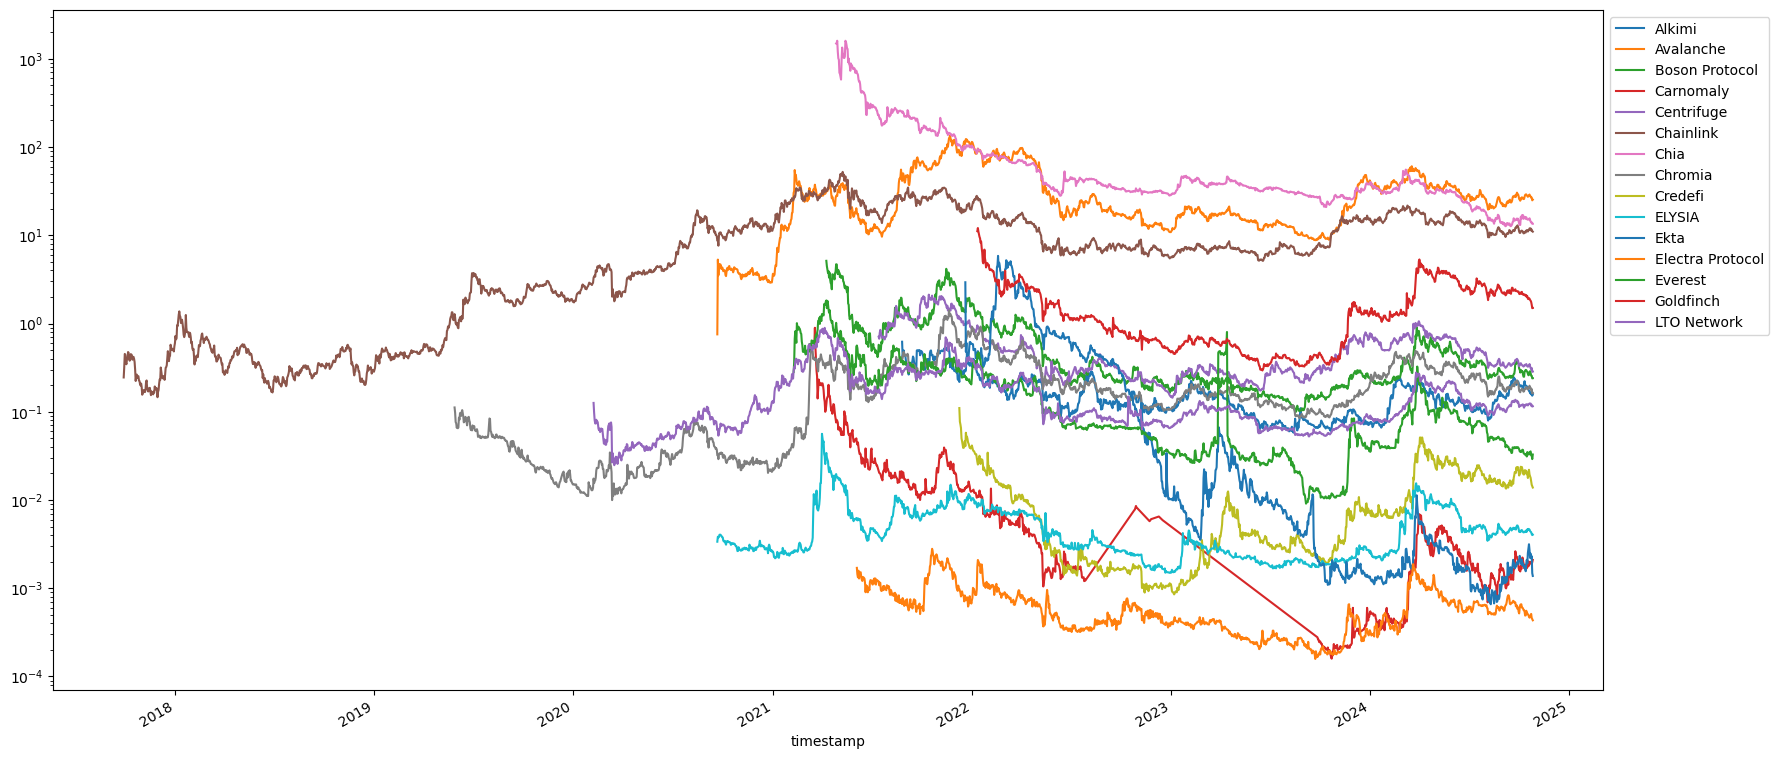

In [86]:
historical_plot(rwa_df)